In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# models
import xgboost as xgb
from sklearn import metrics
from sklearn.utils import resample
import scipy.stats as stats

# Table of Contents

1. [Abstract](#Abstract)
2. [Problem](#Problem)
3. [Data](#Data)
4. [EDA](#EDA)
5. [Model](#Model)
6. [Summary](#Summary)
7. [Future](#Future)

<a id='Abstract'></a>
# Abstract

<a id='Problem'></a>
# Problem

Goal

- One of the greatest data science challenges is fraud, and in general that area of data science related to catching illegal activities, because you often find yourself one step behind.
- Your model is trained on past data. If users come up with a totally new way to commit a fraud, it often takes you some time to be able to react. By the time you get data about that new fraud strategy and retrain the model, many frauds have been already committed.
- A way to overcome this is to use unsupervised machine learning, instead of supervised. With this approach, you don't need to have examples of certain fraud patterns in order to make a prediction. Often, this works by looking at the data and identify sudden clusters of unusual activities.

Challenge Description

- Company XYZ is a major credit card processing startup. It has information about all the transactions that users make with their credit card.
- Your boss knows that fraud can be a huge cost for credit card companies, but isn’t sure if that’s true for your startup. She asks you to first determine if fraud is a major problem and second to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further by a human team of experts.

Hints

- Remember to quantify and describe how you quantify fraud today.  
- How would you validate your model, how would you productionalize it?


<a id='Data'></a>
# Data

In [2]:
!ls Data

TreeDiagram.png              microscopy_3.tif
cc_info.csv                  test_results.csv
cifar-10-batches-py          transactions.csv
dimension_rollup_periods.csv user_table.csv
doggo.jpg                    yammer_emails.csv
employee_retention_data.csv  yammer_events.csv
microscopy.tif               yammer_users.csv
microscopy_2.tif


In [3]:
df_cc = pd.read_csv("Data/cc_info.csv")

In [4]:
df_tran = pd.read_csv("Data/transactions.csv")

The data is very clean

In [5]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
credit_card          984 non-null int64
city                 984 non-null object
state                984 non-null object
zipcode              984 non-null int64
credit_card_limit    984 non-null int64
dtypes: int64(3), object(2)
memory usage: 38.5+ KB


In [6]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [7]:
df = pd.merge(df_cc, df_tran, on="credit_card")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
credit_card                  294588 non-null int64
city                         294588 non-null object
state                        294588 non-null object
zipcode                      294588 non-null int64
credit_card_limit            294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.5+ MB


In [9]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


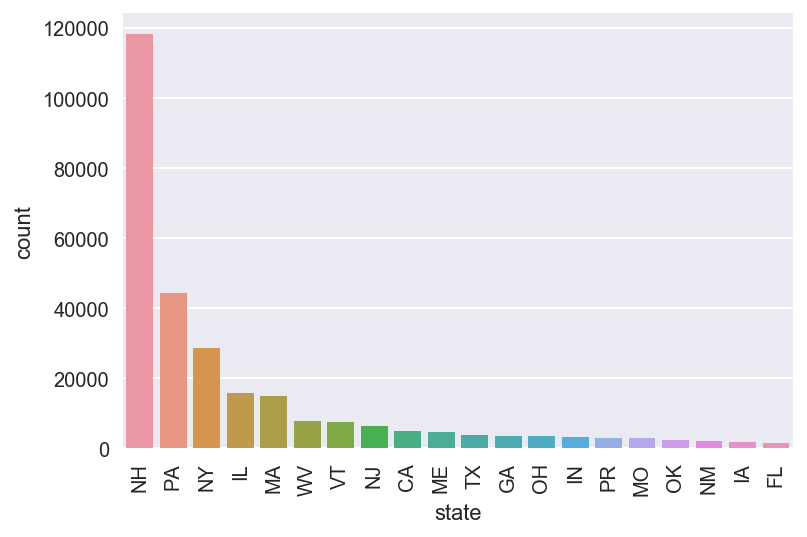

In [10]:
pltstr = 'state'
sns.countplot(x=pltstr, data=df, order=df[pltstr].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

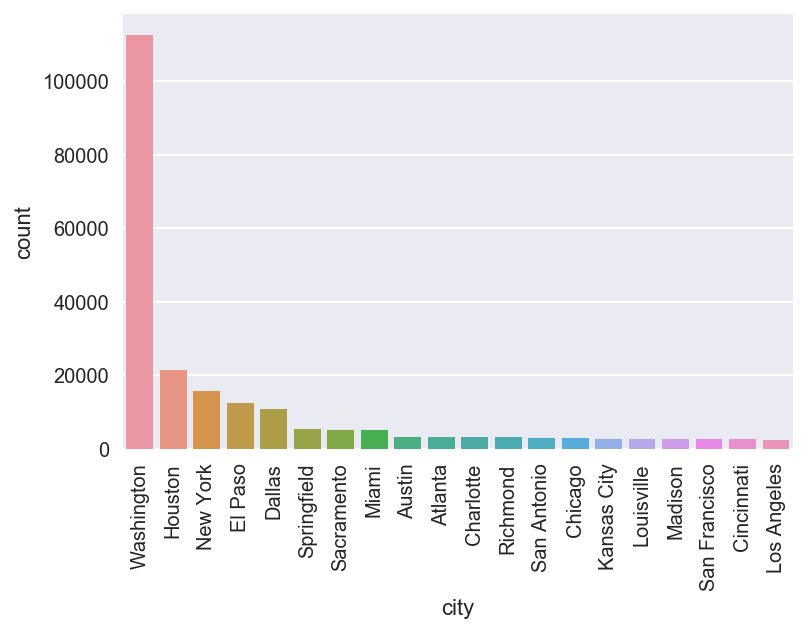

In [11]:
pltstr = 'city'
sns.countplot(x=pltstr, data=df, order=df[pltstr].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

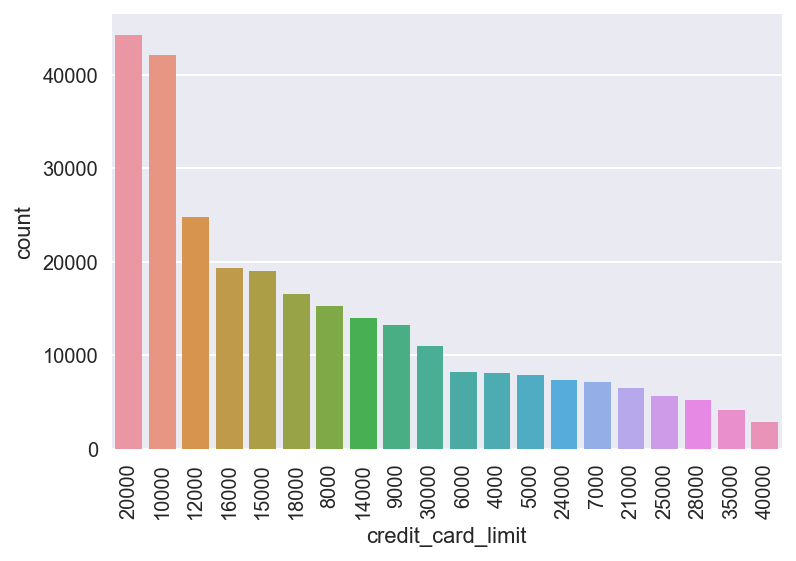

In [12]:
pltstr = 'credit_card_limit'
sns.countplot(x=pltstr, data=df, order=df[pltstr].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

Add day column

In [13]:
df["day"] = pd.to_datetime(df['date']).dt.date

In [14]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,day
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,2015-08-05
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,2015-10-29
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,2015-10-25
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,2015-09-05
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,2015-09-04


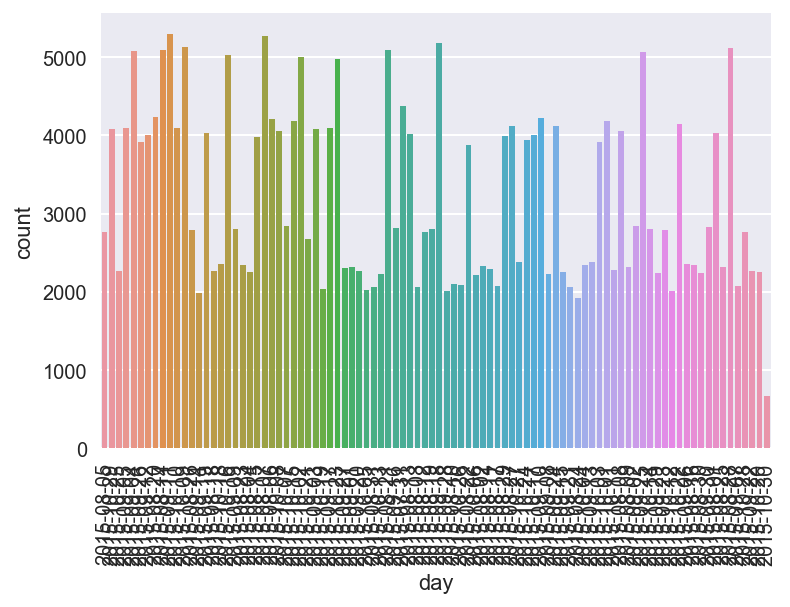

In [15]:
pltstr = 'day'
sns.countplot(x=pltstr, data=df)
plt.xticks(rotation=90)
plt.show()

In [16]:
## !pip install geopy
## https://pypi.org/project/geopy/

In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")

In [18]:
location = geolocator.geocode("Garfield, NJ")
print(location.raw['lat'], location.raw['lon'])

40.8814882 -74.113198


create city state column

In [19]:
df['citystate'] = df[['city', 'state']].apply(lambda x: ', '.join(x), axis=1)

In [20]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,day,citystate
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,2015-08-05,"Dallas, PA"
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,2015-10-29,"Dallas, PA"
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,2015-10-25,"Dallas, PA"
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,2015-09-05,"Dallas, PA"
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,2015-09-04,"Dallas, PA"


In [21]:
city_dic = dict()
for c in df.citystate.unique():
    print(c)
    location = geolocator.geocode(c)
    print(c, location.raw['lat'], location.raw['lon'])
    city_dic[c] = (location.raw['lat'], location.raw['lon'])

Dallas, PA
Dallas, PA 32.3117968 -87.1046643
Houston, PA
Houston, PA 31.1355603 -85.2654592
Auburn, MA
Auburn, MA 42.1945385 -71.8356271
Orlando, WV
Orlando, WV 38.8712074 -80.5937044
New York, NY
New York, NY 40.74123595 -73.356691165361
Atlanta, NY
Atlanta, NY 42.5542347 -77.4724875
Pittsburgh, PA
Pittsburgh, PA 40.4416941 -79.9900861
Birmingham, NJ
Birmingham, NJ 39.9759462 -74.7101596
Washington, NH
Washington, NH 43.17614 -72.097092
Los Angeles, CA
Los Angeles, CA 34.054935 -118.244476
Phoenix, NY
Phoenix, NY 43.231179 -76.300764
Colorado Springs, CO
Colorado Springs, CO 38.8339578 -104.8253485
San Francisco, CA
San Francisco, CA 45.4423543 -73.4373087
Columbus, NJ
Columbus, NJ 40.0726112 -74.7207156
Topeka, IN
Topeka, IN 41.5392165 -85.5397059
El Paso, IL
El Paso, IL 31.7600372 -106.487287
Corpus Christi, TX
Corpus Christi, TX 27.8002542 -97.3955744
Richmond, MA
Richmond, MA 42.3730614 -73.3675552
Sacramento, PA
Sacramento, PA 40.6345309 -76.5888514
Arlington, MA
Arlington, MA 42

In [23]:
## add new column with card holder lat long
df['origin_lat_long'] = df['citystate'].map(city_dic)

In [24]:
df['trans_lat_long'] = df[['Lat', 'Long']].apply(tuple, axis=1)

In [25]:
## geopy.distance.distance accepts coordinates in (y, x)/(lat, lon)

In [26]:
from geopy import distance

In [27]:
distance.distance(df.iloc[0]['origin_lat_long'], df.iloc[0]['trans_lat_long']).km

1409.887946059176

In [28]:
iloc_origin_lat_long = df.columns.get_loc("origin_lat_long")
iloc_trans_lat_long = df.columns.get_loc("trans_lat_long")
def calc_distance(x):
    return distance.distance(x[iloc_origin_lat_long], x[iloc_trans_lat_long]).km

In [29]:
## calculate the distance between the transaction and the origin
df['dist'] = df.apply(calc_distance, axis=1)

In [30]:
df.describe()

,credit_card,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,dist
count,2.945880e+05,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,18073.772516,15502.053716,86.008036,-76.235238,40.937669,559.291018
std,2.555803e+15,23945.510551,7956.291556,124.655954,20.135015,5.391695,1606.806926
min,1.003715e+15,690.000000,2000.000000,0.010000,-179.392887,-68.046553,0.025687
25%,3.344214e+15,3280.000000,10000.000000,29.970000,-80.209708,40.487726,5.200274
50%,5.353426e+15,5820.000000,15000.000000,58.470000,-73.199737,42.403066,7.526015
75%,7.646245e+15,18612.000000,20000.000000,100.400000,-72.091933,43.180015,51.697636
max,9.999757e+15,98401.000000,55000.000000,999.970000,179.917513,78.914330,19743.751598


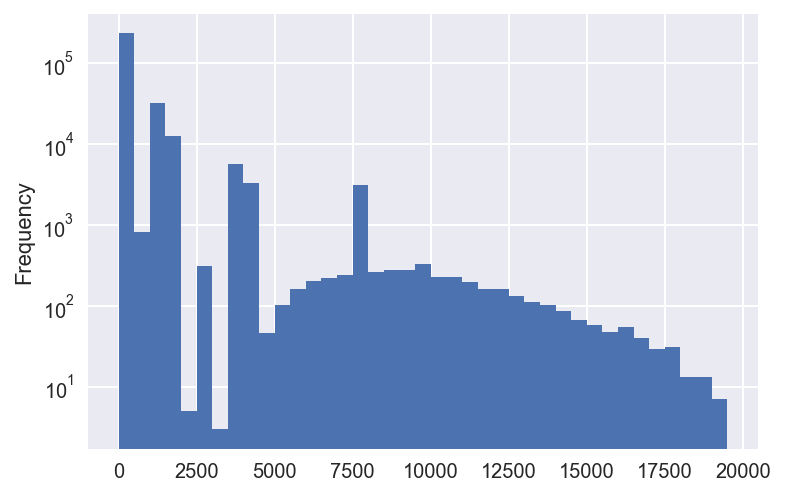

In [31]:
df['dist'].plot(kind='hist', bins=np.arange(0, 20000, 500), logy=True)
plt.show()

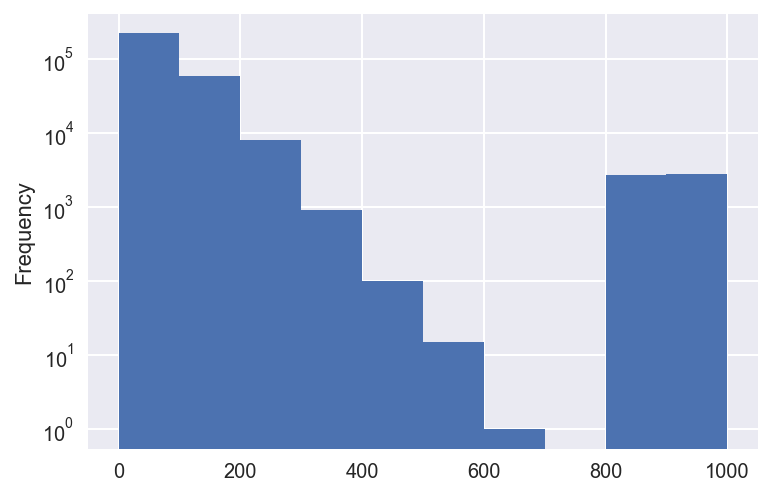

In [32]:
df['transaction_dollar_amount'].plot(kind='hist', logy=True)
plt.show()

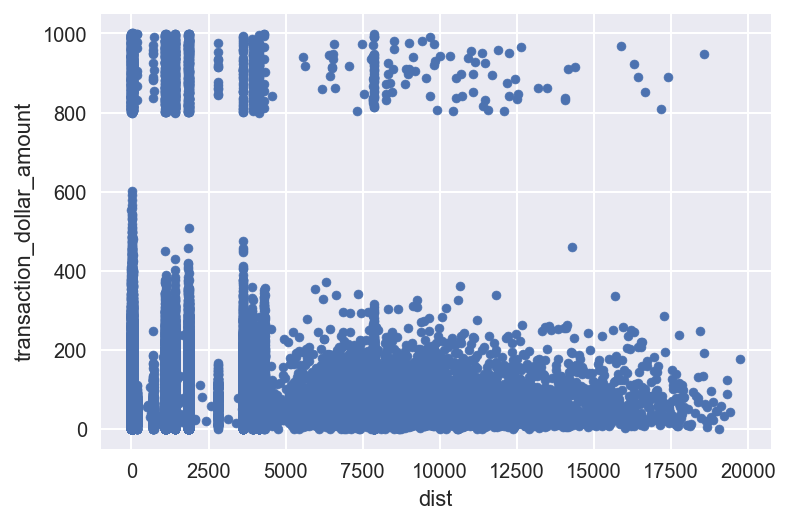

In [33]:
df.plot.scatter(x='dist', y='transaction_dollar_amount')
plt.show()

In [34]:
## need to check per-month how much does each card spend
df["month"] = pd.to_datetime(df['date']).dt.month

In [35]:
df = df.sort_values(["month", "credit_card"]).reset_index()

In [37]:
#df = df.drop(['level_0', 'index'], axis=1)

In [38]:
df.shape

(294588, 16)

In [39]:
df.groupby(["month"], as_index=False)["transaction_dollar_amount"].sum()

,month,transaction_dollar_amount
0,7,372043.19
1,8,8527676.09
2,9,8221596.40
3,10,8215619.68


In [40]:
df.groupby(["month"], as_index=False)["credit_card"].nunique()

0    861
1    977
2    978
3    981
Name: credit_card, dtype: int64

In [41]:
df.groupby(["month"], as_index=False).count()

,month,index,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,day,citystate,origin_lat_long,trans_lat_long,dist
0,7,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381,4381
1,8,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167,99167
2,9,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026,96026
3,10,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014,95014


In [42]:
df["monthly_trans"] = df.groupby(["month", "credit_card"])['transaction_dollar_amount'].transform('sum')

In [43]:
df["monthly_trans_ratio"] = df["monthly_trans"]/df["credit_card_limit"]

In [44]:
df.describe()

,index,credit_card,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,dist,month,monthly_trans,monthly_trans_ratio
count,294588.000000,2.945880e+05,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,147293.500000,5.424562e+15,18073.772516,15502.053716,86.008036,-76.235238,40.937669,559.291018,8.956159,11538.795346,0.736928
std,85040.374887,2.555803e+15,23945.510551,7956.291556,124.655954,20.135015,5.391695,1606.806926,0.846598,7108.401825,0.247667
min,0.000000,1.003715e+15,690.000000,2000.000000,0.010000,-179.392887,-68.046553,0.025687,7.000000,5.670000,0.000567
25%,73646.750000,3.344214e+15,3280.000000,10000.000000,29.970000,-80.209708,40.487726,5.200274,8.000000,6239.280000,0.597373
50%,147293.500000,5.353426e+15,5820.000000,15000.000000,58.470000,-73.199737,42.403066,7.526015,9.000000,10408.600000,0.756987
75%,220940.250000,7.646245e+15,18612.000000,20000.000000,100.400000,-72.091933,43.180015,51.697636,10.000000,15586.850000,0.879896
max,294587.000000,9.999757e+15,98401.000000,55000.000000,999.970000,179.917513,78.914330,19743.751598,10.000000,51569.820000,1.992810


In [45]:
df.loc[df.duplicated(keep='first'), :]

,index,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,day,citystate,origin_lat_long,trans_lat_long,dist,month,monthly_trans,monthly_trans_ratio


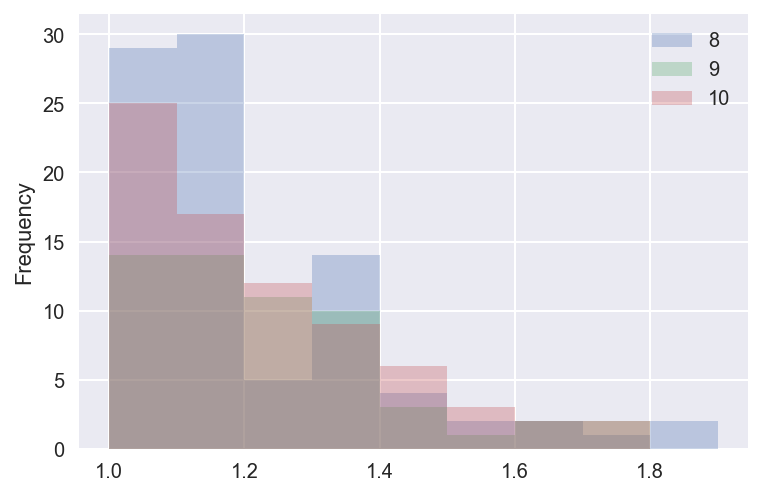

In [56]:
## for each card, each month, only plot once
#df.loc[df["month"] == 7].drop_duplicates(["credit_card"])['monthly_trans_ratio'].plot(kind='hist',  bins=np.arange(1, 2, 0.1), alpha=0.5, label='7')
df.loc[df["month"] == 8].drop_duplicates(["credit_card"])['monthly_trans_ratio'].plot(kind='hist',  bins=np.arange(1, 2, 0.1), alpha=0.3, label='8')
df.loc[df["month"] == 9].drop_duplicates(["credit_card"])['monthly_trans_ratio'].plot(kind='hist',  bins=np.arange(1, 2, 0.1), alpha=0.3, label='9')
df.loc[df["month"] == 10].drop_duplicates(["credit_card"])['monthly_trans_ratio'].plot(kind='hist',  bins=np.arange(1, 2, 0.1), alpha=0.3, label='10')
plt.legend()
plt.show()

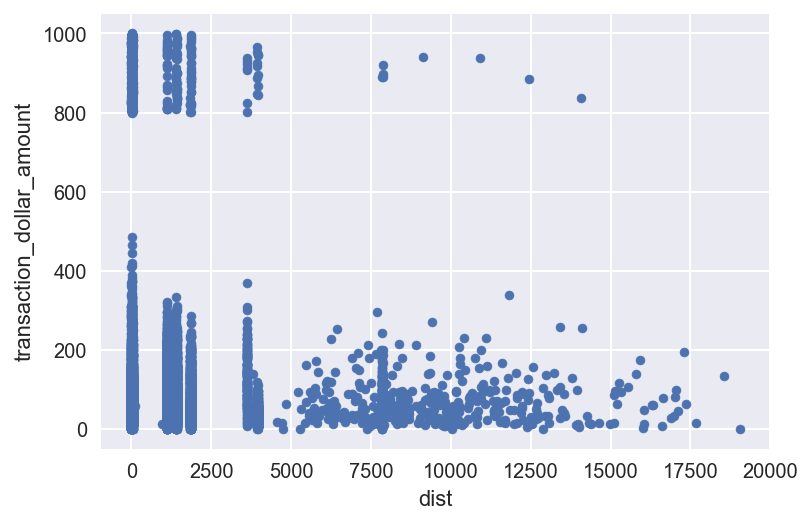

In [47]:
df.loc[df['monthly_trans_ratio'] >= 0.99].plot.scatter(x='dist', y='transaction_dollar_amount')
plt.show()

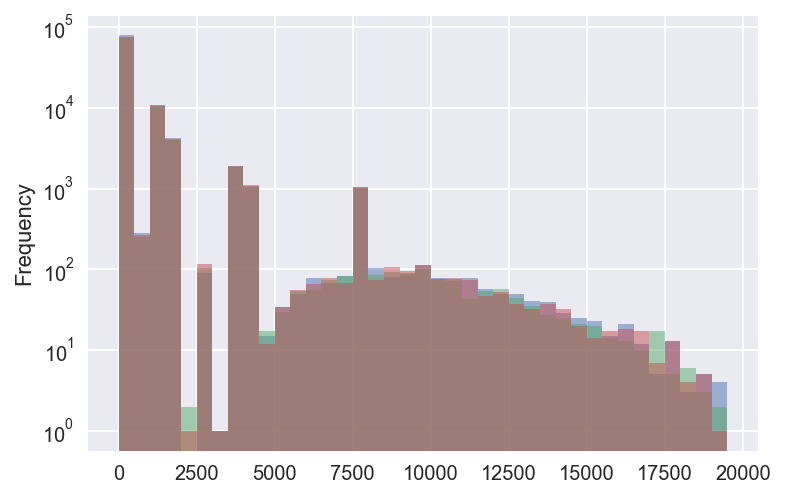

In [48]:
df.loc[df["month"] == 8]['dist'].plot(kind='hist', bins=np.arange(0, 20000, 500), logy=True, alpha=0.5)
df.loc[df["month"] == 9]['dist'].plot(kind='hist', bins=np.arange(0, 20000, 500), logy=True, alpha=0.5)
df.loc[df["month"] == 10]['dist'].plot(kind='hist', bins=np.arange(0, 20000, 500), logy=True, alpha=0.5)
plt.show()

<a id='EDA'></a>
# EDA

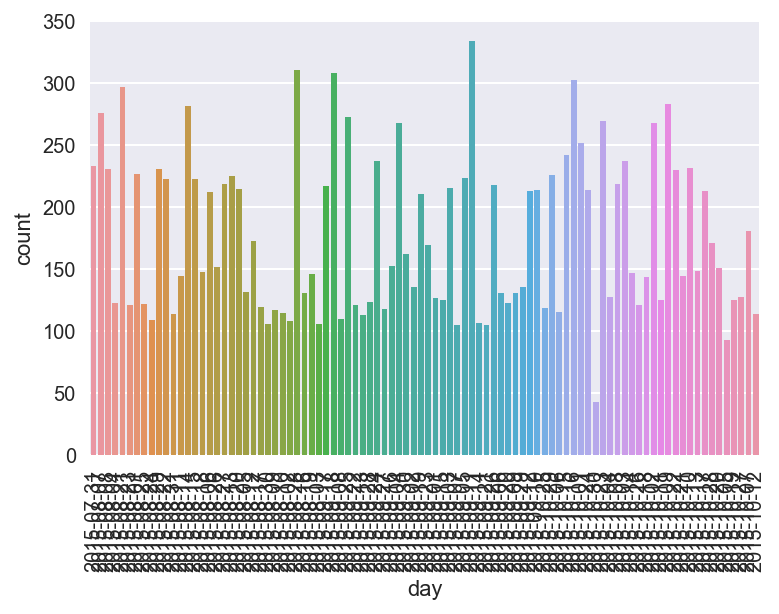

In [49]:
## check if large amount, far away, what time trend, how many cards do they have
pltstr = 'day'
sns.countplot(x=pltstr, data=df.loc[df['dist'] > 2500])
plt.xticks(rotation=90)
plt.show()

In [50]:
df.loc[df['dist'] > 2500]['credit_card'].nunique()

873

In [51]:
df.loc[df['transaction_dollar_amount'] > 700]['credit_card'].nunique()

897

In [52]:
print(df.loc[(df['transaction_dollar_amount'] > 700) & (df['dist'] > 2500)]['credit_card'].nunique())
print(df.loc[(df['transaction_dollar_amount'] > 700) & (df['dist'] > 2500)]['credit_card'].value_counts())

109
7628993515975118    14
7492940622489570    12
6514175342145589    12
5059189477453448    10
2216132730528773    10
8239191573771235    10
4172354071638301     9
6744701624115884     9
8123289635641903     9
5488856737032471     8
6598829254424957     8
1800690977956392     8
3831759517786458     7
9552288592156524     7
7728317158402059     7
7524708568363224     6
7768299333443860     6
1981294676906345     6
8415836921156758     6
6063334769611138     5
7338934618553557     5
4213842418098364     5
9430574789596024     5
4309494627223049     5
6202290276245949     4
7745651081413913     3
8117664962797683     3
3153643853817761     3
4787957227319660     3
9737219864179988     2
                    ..
9594995194184360     1
1169271395749970     1
6404482075284890     1
6898559558056681     1
1997929794676601     1
3367848759678576     1
1505998080559428     1
5405790922747020     1
5700924993541613     1
2964226721442922     1
1175962294549313     1
7087720787493988     1
4140252

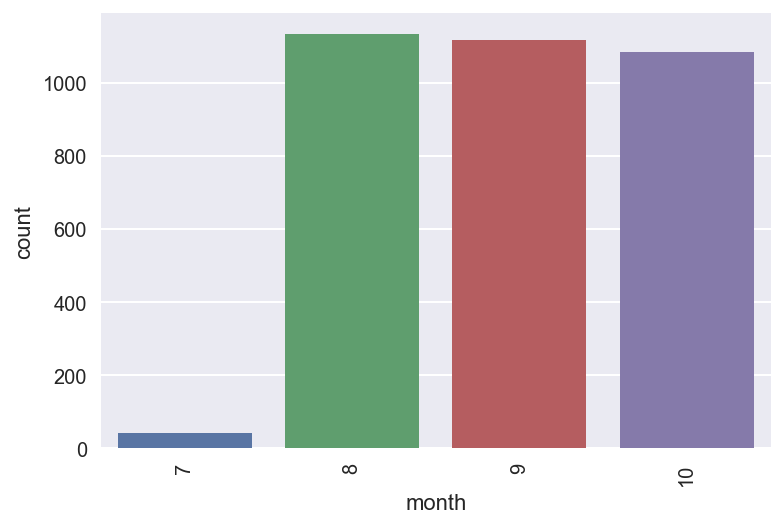

In [58]:
pltstr = 'month'
sns.countplot(x=pltstr, data=df.loc[(df['dist'] > 7000)&(df['dist'] < 8000)])
plt.xticks(rotation=90)
plt.show()

<a id='Model'></a>
# Model

<a id='Summary'></a>
# Summary

<a id='Future'></a>
# Future